In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,accuracy_score

In [2]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

Using TensorFlow backend.


In [3]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [4]:
from keras import backend as K
import tensorflow as tf
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        
        # scale predictions so that the class probas of each sample sum to 1
        
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = (y_true * K.log(y_pred) * weights[0] + (1.0 - y_true) * K.log(1.0 - y_pred) * weights[1])
        loss = -K.sum(loss, -1)
        return loss / 100
    
    return loss

In [5]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        #print(result)
        return np.sum(result)

In [6]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
#df.info()

In [7]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [8]:
df['swell'] = df['swell']# + df['weather_deterioration']

In [9]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [10]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [11]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [12]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    #df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    #df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    #df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    
    #df.drop(['month', 'lunar_month'], axis=1, inplace=True)
    df.drop(['month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    #df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    #df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    #df.drop(['day', 'lunar_day'], axis=1, inplace=True)
    df.drop(['day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)
    df.drop(['week'],axis=1,inplace=True)

In [13]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [14]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [15]:
s[s > 10].index.tolist()[0]

20170315

In [16]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [17]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [18]:
get_prev_date('20170101')

'2016123100'

In [19]:
get_today_from_07('20170101')

'2017010100'

In [20]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [21]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    day = get_prev_date(d)
    #day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    #print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

600

### features
* SEQ_FEATURES: ['swell', ... ,'파주기']
* AUX_FEATURES: ['day_hour', 'year', 'month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin','weekday_cos']
* TARGET_FEATURES: ['swell(t+1) ... swell(t+24)']

In [22]:
df['hour'] = df['hour'].astype(str)
df.set_index('hour',inplace=True,drop=True)

In [23]:
drop_features = ['climate','weather_deterioration','day_hour']
aux_features = ['year','month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin','weekday_cos']

In [24]:
test_date_hour = sorted(test_date_hour)
test_date = test_date_hour[0:24]
test_date

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806']

In [25]:
all_df = df.loc[:test_date[-1]].drop(drop_features,axis=1)
all_df.tail(10)

,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),22490_수온(°C),22490_최대파고(m),22490_유의파고(m),22490_평균파고(m),...,22189_평균파고(m),22189_파주기(sec),22189_파향(deg),year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
hour,,,,,,,,,,,,,,,,,,,,,
2014051721,1.0,17.7,1.3,1.0,0.6,9.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349
2014051722,1.0,17.3,1.5,1.2,0.7,9.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349
2014051723,1.0,17.0,1.4,1.1,0.7,8.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349
2014051800,1.0,17.0,1.6,1.2,0.7,9.1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000
2014051801,1.0,17.0,1.5,1.1,0.7,8.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000
2014051802,1.0,16.7,1.8,1.2,0.8,8.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000
2014051803,1.0,16.5,1.5,1.2,0.7,8.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000
2014051804,1.0,16.4,1.2,1.1,0.7,8.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000
2014051805,1.0,16.3,1.2,1.0,0.6,8.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000


In [26]:
all_size = len(all_df)
col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
possible_cols = col_df[col_df[0]==True].index.tolist()
possible_cols

['swell',
 '22453_수온(°C)',
 '22453_최대파고(m)',
 '22453_유의파고(m)',
 '22453_평균파고(m)',
 '22453_파주기(sec)',
 '21229_GUST풍속 1(m/s)',
 '21229_기온(°C)',
 '21229_수온(°C)',
 '21229_습도(%)',
 '21229_유의파고(m)',
 '21229_최대파고(m)',
 '21229_파주기(sec)',
 '21229_파향(deg)',
 '21229_평균파고(m)',
 '21229_풍속1(m/s)',
 '21229_풍향1(deg)',
 '21229_현지기압(hPa)',
 '22105_GUST풍속 1(m/s)',
 '22105_기온(°C)',
 '22105_수온(°C)',
 '22105_습도(%)',
 '22105_유의파고(m)',
 '22105_최대파고(m)',
 '22105_파주기(sec)',
 '22105_파향(deg)',
 '22105_평균파고(m)',
 '22105_풍속1(m/s)',
 '22105_풍향1(deg)',
 '22105_현지기압(hPa)',
 '22106_GUST풍속 1(m/s)',
 '22106_기온(°C)',
 '22106_수온(°C)',
 '22106_습도(%)',
 '22106_유의파고(m)',
 '22106_최대파고(m)',
 '22106_파주기(sec)',
 '22106_파향(deg)',
 '22106_평균파고(m)',
 '22106_풍속1(m/s)',
 '22106_풍향1(deg)',
 '22106_현지기압(hPa)',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'weekday_sin',
 'weekday_cos']

In [27]:
possible_df = all_df[possible_cols].copy()
possible_df.tail()
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 2014010407 to 2014051806
Data columns (total 49 columns):
swell                  3216 non-null float64
22453_수온(°C)           3117 non-null float64
22453_최대파고(m)          3117 non-null float64
22453_유의파고(m)          3117 non-null float64
22453_평균파고(m)          3117 non-null float64
22453_파주기(sec)         3117 non-null float64
21229_GUST풍속 1(m/s)    3203 non-null float64
21229_기온(°C)           3203 non-null float64
21229_수온(°C)           3163 non-null float64
21229_습도(%)            3203 non-null float64
21229_유의파고(m)          3201 non-null float64
21229_최대파고(m)          3201 non-null float64
21229_파주기(sec)         3203 non-null float64
21229_파향(deg)          3203 non-null float64
21229_평균파고(m)          3201 non-null float64
21229_풍속1(m/s)         3203 non-null float64
21229_풍향1(deg)         3203 non-null float64
21229_현지기압(hPa)        3192 non-null float64
22105_GUST풍속 1(m/s)    3208 non-null float64
22105_기온(°C)           3208 

In [28]:
possible_df.fillna(method='ffill',inplace=True)
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 2014010407 to 2014051806
Data columns (total 49 columns):
swell                  3216 non-null float64
22453_수온(°C)           3216 non-null float64
22453_최대파고(m)          3216 non-null float64
22453_유의파고(m)          3216 non-null float64
22453_평균파고(m)          3216 non-null float64
22453_파주기(sec)         3216 non-null float64
21229_GUST풍속 1(m/s)    3216 non-null float64
21229_기온(°C)           3216 non-null float64
21229_수온(°C)           3216 non-null float64
21229_습도(%)            3216 non-null float64
21229_유의파고(m)          3216 non-null float64
21229_최대파고(m)          3216 non-null float64
21229_파주기(sec)         3216 non-null float64
21229_파향(deg)          3216 non-null float64
21229_평균파고(m)          3216 non-null float64
21229_풍속1(m/s)         3216 non-null float64
21229_풍향1(deg)         3216 non-null float64
21229_현지기압(hPa)        3216 non-null float64
22105_GUST풍속 1(m/s)    3216 non-null float64
22105_기온(°C)           3216 

In [29]:
seq_features = possible_df.columns.drop(aux_features).tolist()

### add_seqeunce

In [30]:
inseq = 6

temp_cols = []
temp_names = []
for i in range(1,inseq):
    temp_cols.append(possible_df[seq_features].shift(i))
    temp_names += [feature_name+'(t-{})'.format(i) for feature_name in seq_features]

seq_df = pd.concat(temp_cols,axis=1)
seq_df.columns = temp_names
seq_features = seq_df.columns
possible_df = pd.concat([possible_df,seq_df],axis=1).iloc[inseq+1:]
possible_df.info()

In [33]:
outseq = 24
target_feature = ['swell']

temp_cols = []
temp_names = []
for i in range(1,outseq+1):
    temp_cols.append(possible_df[target_feature].shift(-i))
    temp_names += [feature_name+'(t+{})'.format(i) for feature_name in target_feature]

In [35]:
temp_names

['swell(t+1)',
 'swell(t+2)',
 'swell(t+3)',
 'swell(t+4)',
 'swell(t+5)',
 'swell(t+6)',
 'swell(t+7)',
 'swell(t+8)',
 'swell(t+9)',
 'swell(t+10)',
 'swell(t+11)',
 'swell(t+12)',
 'swell(t+13)',
 'swell(t+14)',
 'swell(t+15)',
 'swell(t+16)',
 'swell(t+17)',
 'swell(t+18)',
 'swell(t+19)',
 'swell(t+20)',
 'swell(t+21)',
 'swell(t+22)',
 'swell(t+23)',
 'swell(t+24)']

In [36]:
target_seq_df = pd.concat(temp_cols,axis=1)
target_seq_df.columns = temp_names
sequence_target_features = target_seq_df.columns
possible_df = pd.concat([possible_df,target_seq_df],axis=1).iloc[:-(outseq)]
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3185 entries, 2014010414 to 2014051706
Columns: 283 entries, swell to swell(t+24)
dtypes: float64(283)
memory usage: 6.9+ MB


In [37]:
train_X = possible_df.iloc[:-24-24].drop(sequence_target_features.tolist() + aux_features,axis=1)
train_X.tail()

,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),...,22106_수온(°C)(t-5),22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5)
hour,,,,,,,,,,,,,,,,,,,,,
2014051502,0.0,16.1,0.2,0.2,0.1,3.7,5.3,15.6,14.7,82.0,...,17.0,68.0,0.8,1.5,3.8,352.0,0.6,7.2,214.0,998.6
2014051503,0.0,16.2,0.3,0.2,0.1,4.1,4.5,15.8,14.6,80.0,...,17.0,69.0,0.6,1.0,3.6,23.0,0.4,6.3,204.0,998.6
2014051504,0.0,16.0,0.2,0.2,0.1,3.8,2.2,15.5,14.7,83.0,...,16.9,71.0,0.5,0.7,3.8,343.0,0.3,4.1,207.0,997.8
2014051505,0.0,15.9,0.3,0.2,0.1,4.0,4.2,15.7,14.8,82.0,...,16.9,77.0,0.4,0.7,3.6,339.0,0.3,4.2,200.0,997.4
2014051506,0.0,15.8,0.3,0.2,0.1,3.7,4.0,15.4,14.8,84.0,...,16.9,76.0,0.3,0.5,3.8,334.0,0.2,4.2,203.0,996.7


In [38]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
train_X.loc[:,:] = feature_scaler.fit_transform(train_X.values)

In [39]:
feature_len = len(train_X.columns) // inseq
feature_len

42

In [40]:
train_y = possible_df.iloc[:-24-24][sequence_target_features]
train_y.tail()

,swell(t+1),swell(t+2),swell(t+3),swell(t+4),swell(t+5),swell(t+6),swell(t+7),swell(t+8),swell(t+9),swell(t+10),...,swell(t+15),swell(t+16),swell(t+17),swell(t+18),swell(t+19),swell(t+20),swell(t+21),swell(t+22),swell(t+23),swell(t+24)
hour,,,,,,,,,,,,,,,,,,,,,
2014051502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014051503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014051504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014051505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014051506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
test_X = pd.DataFrame(possible_df.iloc[-1:])\
                .drop(sequence_target_features.tolist() + aux_features,axis=1)
test_X.loc[:,:] = feature_scaler.transform(test_X.values)
test_X

,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),...,22106_수온(°C)(t-5),22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5)
hour,,,,,,,,,,,,,,,,,,,,,
2014051706,0.0,0.676471,0.166667,0.2,0.192308,0.969697,0.192593,0.772321,0.722222,0.672131,...,0.986301,0.788732,0.372549,0.367089,0.657407,0.558333,0.388889,0.074713,0.988889,0.42735


In [52]:
test_y = pd.DataFrame(possible_df.iloc[-1:])\
                [sequence_target_features]
test_y

,swell(t+1),swell(t+2),swell(t+3),swell(t+4),swell(t+5),swell(t+6),swell(t+7),swell(t+8),swell(t+9),swell(t+10),...,swell(t+15),swell(t+16),swell(t+17),swell(t+18),swell(t+19),swell(t+20),swell(t+21),swell(t+22),swell(t+23),swell(t+24)
hour,,,,,,,,,,,,,,,,,,,,,
2014051706,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [53]:
size = len(train_X)
add_size = 100 - size%100

train_X = pd.concat([train_X,train_X.head(add_size)])
train_y = pd.concat([train_y,train_y.head(add_size)])

print(train_X.shape,train_y.shape)

size = len(test_X)
add_size = 100 - size%100

test_X = pd.concat([test_X,test_X.sample(add_size,replace=True)])
test_y = pd.concat([test_y,test_y.sample(add_size,replace=True)])

print(test_X.shape,test_y.shape)



(3300, 252) (3300, 24)
(100, 252) (100, 24)


In [54]:
def baseline_model(shape, batch_size):
    main_input = Input(shape=(shape[1], shape[2]),
                       batch_shape=(batch_size, shape[1], shape[2]), name='main_input')

    x = LSTM(64, return_sequences=True, stateful=True)(main_input)
    x = LSTM(32, return_sequences=True, stateful=True)(x)
    x = LSTM(32, return_sequences=True, stateful=True)(x)
    x = LSTM(32, stateful=True)(x)

    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    main_output = Dense(outseq, activation='sigmoid')(x)

    model = Model(inputs=main_input, outputs=main_output)
    weights = np.array([1,9])
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer='adam', metrics=['acc'])

    return model

In [55]:
%%time
model = baseline_model((100,inseq,feature_len),100)
model.fit(train_X.values.reshape(-1,inseq,feature_len),train_y.values,batch_size=100,
          validation_data=(test_X.values.reshape(-1,inseq,feature_len),test_y.values),epochs=200)

Train on 3300 samples, validate on 100 samples
Epoch 1/200
3300/3300 [==============================] - 4s - loss: 0.8988 - acc: 0.0058 - val_loss: 0.6142 - val_acc: 0.0000e+00
Epoch 2/200
3300/3300 [==============================] - 1s - loss: 0.1443 - acc: 0.0055 - val_loss: 0.9546 - val_acc: 0.0000e+00
Epoch 3/200
3300/3300 [==============================] - 2s - loss: 0.1152 - acc: 0.0042 - val_loss: 0.8302 - val_acc: 0.0000e+00
Epoch 4/200
3300/3300 [==============================] - 1s - loss: 0.1124 - acc: 0.0042 - val_loss: 0.8097 - val_acc: 0.0000e+00
Epoch 5/200
3300/3300 [==============================] - 2s - loss: 0.1117 - acc: 0.0045 - val_loss: 0.8374 - val_acc: 0.0000e+00
Epoch 6/200
3300/3300 [==============================] - 1s - loss: 0.1115 - acc: 0.0048 - val_loss: 0.8337 - val_acc: 0.0000e+00
Epoch 7/200
3300/3300 [==============================] - 1s - loss: 0.1115 - acc: 0.2897 - val_loss: 0.8377 - val_acc: 0.0000e+00
Epoch 8/200
3300/3300 [====================

3300/3300 [==============================] - 1s - loss: 0.0622 - acc: 0.0309 - val_loss: 1.9126 - val_acc: 0.0000e+00
Epoch 64/200
3300/3300 [==============================] - 1s - loss: 0.0618 - acc: 0.0182 - val_loss: 1.9966 - val_acc: 0.0000e+00
Epoch 65/200
3300/3300 [==============================] - 1s - loss: 0.0610 - acc: 0.0248 - val_loss: 2.0009 - val_acc: 0.0000e+00
Epoch 66/200
3300/3300 [==============================] - 1s - loss: 0.0610 - acc: 0.0285 - val_loss: 1.9964 - val_acc: 0.0000e+00
Epoch 67/200
3300/3300 [==============================] - 1s - loss: 0.0605 - acc: 0.0242 - val_loss: 2.1129 - val_acc: 0.0000e+00
Epoch 68/200
3300/3300 [==============================] - 1s - loss: 0.0633 - acc: 0.0221 - val_loss: 1.9241 - val_acc: 0.0000e+00
Epoch 69/200
3300/3300 [==============================] - 2s - loss: 0.0611 - acc: 0.0315 - val_loss: 2.0657 - val_acc: 0.0000e+00
Epoch 70/200
3300/3300 [==============================] - 2s - loss: 0.0604 - acc: 0.0352 - val_

3300/3300 [==============================] - 1s - loss: 0.0564 - acc: 0.0082 - val_loss: 2.4476 - val_acc: 0.0000e+00
Epoch 126/200
3300/3300 [==============================] - 1s - loss: 0.0543 - acc: 0.0264 - val_loss: 2.4848 - val_acc: 0.0000e+00
Epoch 127/200
3300/3300 [==============================] - 1s - loss: 0.0539 - acc: 0.0267 - val_loss: 2.5044 - val_acc: 0.0000e+00
Epoch 128/200
3300/3300 [==============================] - 1s - loss: 0.0535 - acc: 0.0267 - val_loss: 2.4960 - val_acc: 0.0000e+00
Epoch 129/200
3300/3300 [==============================] - 1s - loss: 0.0527 - acc: 0.0218 - val_loss: 2.4693 - val_acc: 0.0000e+00
Epoch 130/200
3300/3300 [==============================] - 1s - loss: 0.0532 - acc: 0.0324 - val_loss: 2.4313 - val_acc: 0.0000e+00
Epoch 131/200
3300/3300 [==============================] - 1s - loss: 0.0533 - acc: 0.0291 - val_loss: 2.4387 - val_acc: 0.0000e+00
Epoch 132/200
3300/3300 [==============================] - 1s - loss: 0.0532 - acc: 0.1139

3300/3300 [==============================] - 1s - loss: 0.0332 - acc: 0.0897 - val_loss: 2.5070 - val_acc: 0.0000e+00
Epoch 188/200
3300/3300 [==============================] - 1s - loss: 0.0317 - acc: 0.0815 - val_loss: 2.5033 - val_acc: 0.0000e+00
Epoch 189/200
3300/3300 [==============================] - 2s - loss: 0.0315 - acc: 0.0812 - val_loss: 2.5010 - val_acc: 0.0000e+00
Epoch 190/200
3300/3300 [==============================] - 2s - loss: 0.0321 - acc: 0.0815 - val_loss: 2.5065 - val_acc: 0.0000e+00
Epoch 191/200
3300/3300 [==============================] - 2s - loss: 0.0317 - acc: 0.0767 - val_loss: 2.4589 - val_acc: 0.0000e+00
Epoch 192/200
3300/3300 [==============================] - 2s - loss: 0.0315 - acc: 0.0727 - val_loss: 2.5145 - val_acc: 0.0000e+00
Epoch 193/200
3300/3300 [==============================] - 1s - loss: 0.0306 - acc: 0.0748 - val_loss: 2.5154 - val_acc: 0.0000e+00
Epoch 194/200
3300/3300 [==============================] - 2s - loss: 0.0317 - acc: 0.0779

In [60]:
pred = model.predict(test_X.values.reshape(-1,inseq,feature_len),batch_size=100)

In [61]:
pred.shape

(100, 24)

In [62]:
test_df = pd.DataFrame(np.round(pred[:1],3),columns=sequence_target_features,index=test_X.index[:1]).T
test_df['real_swell'] = test_y.iloc[0]

In [63]:
test_df

hour,2014051706,real_swell
swell(t+1),0.0,0.0
swell(t+2),0.0,0.0
swell(t+3),0.0,0.0
swell(t+4),0.0,0.0
swell(t+5),0.0,0.0
swell(t+6),0.0,0.0
swell(t+7),0.0,1.0
swell(t+8),0.0,1.0
swell(t+9),0.0,1.0
swell(t+10),0.0,1.0


In [70]:
%%time

model_scores = []
imp_features = []
preds = [] 
probas = []

for i in range(25):
    st = time.time()
    index = i*24
    test_date = test_date_hour[index:index+24]
    all_df = df.loc[:test_date[-1]].drop(drop_features,axis=1)
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.12)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    
    possible_df = all_df[possible_cols].copy()
    possible_df.fillna(method='ffill',inplace=True)
    
    seq_features = possible_df.columns.drop(aux_features).tolist()
    
    inseq = 6

    temp_cols = []
    temp_names = []
    for i in range(1,inseq):
        temp_cols.append(possible_df[seq_features].shift(i))
        temp_names += [feature_name+'(t-{})'.format(i) for feature_name in seq_features]

    seq_df = pd.concat(temp_cols,axis=1)
    seq_df.columns = temp_names
    seq_features = seq_df.columns
    possible_df = pd.concat([possible_df,seq_df],axis=1).iloc[inseq+1:]
    
    outseq = 24
    target_feature = ['swell']

    temp_cols = []
    temp_names = []
    for i in range(1,outseq+1):
        temp_cols.append(possible_df[target_feature].shift(-i))
        temp_names += [feature_name+'(t+{})'.format(i) for feature_name in target_feature]
    
    target_seq_df = pd.concat(temp_cols,axis=1)
    target_seq_df.columns = temp_names
    sequence_target_features = target_seq_df.columns
    possible_df = pd.concat([possible_df,target_seq_df],axis=1).iloc[:-(outseq)]
    
    train_X = possible_df.iloc[:-24-24].drop(sequence_target_features.tolist() + aux_features,axis=1)
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    train_X.loc[:,:] = feature_scaler.fit_transform(train_X.values)

    feature_len = len(train_X.columns) // inseq
    
    train_y = possible_df.iloc[:-24-24][sequence_target_features]
    
    test_X = pd.DataFrame(possible_df.iloc[-1:])\
                .drop(sequence_target_features.tolist() + aux_features,axis=1)
    test_X.loc[:,:] = feature_scaler.transform(test_X.values)
    
    test_y = pd.DataFrame(possible_df.iloc[-1:])\
                [sequence_target_features]
        
    size = len(train_X)
    add_size = 100 - size%100

    train_X = pd.concat([train_X,train_X.head(add_size)])
    train_y = pd.concat([train_y,train_y.head(add_size)])

    size = len(test_X)
    add_size = 100 - size%100

    test_X = pd.concat([test_X,test_X.sample(add_size,replace=True)])
    test_y = pd.concat([test_y,test_y.sample(add_size,replace=True)])
    
    model = baseline_model((100,inseq,feature_len),100)
    model.fit(train_X.values.reshape(-1,inseq,feature_len),train_y.values,batch_size=100,epochs=10)
    
    pred = model.predict(test_X.values.reshape(-1,inseq,feature_len),batch_size=100)[0]
    
    test_df = pd.DataFrame(pred[:1],columns=sequence_target_features,index=test_X.index[:1]).T
    test_df['real_swell'] = test_y.iloc[0]
    
    preds.append(pred)

    print(index,'train {} ~ {} size: {}, test {}, {} sec'\
               .format(train_X.index.tolist()[0],train_X.index.tolist()[-1], len(train_X),test_X.index.tolist()[0],round(time.time()-st,2)))
    print(test_df.loc[:,test_df.columns[0]].apply(round,args=(2,)).tolist())
    print(test_df.loc[:,test_df.columns[1]].astype(int).tolist())

Epoch 1/10
3200/3200 [==============================] - 8s - loss: 1.0035 - acc: 0.0047     
Epoch 2/10
3200/3200 [==============================] - 1s - loss: 0.1661 - acc: 0.0050     
Epoch 3/10
3200/3200 [==============================] - 1s - loss: 0.1176 - acc: 0.0059     
Epoch 4/10
3200/3200 [==============================] - 1s - loss: 0.1136 - acc: 0.0050     
Epoch 5/10
3200/3200 [==============================] - 1s - loss: 0.1133 - acc: 0.0053     
Epoch 6/10
3200/3200 [==============================] - 1s - loss: 0.1133 - acc: 0.1147     
Epoch 7/10
3200/3200 [==============================] - 1s - loss: 0.1133 - acc: 0.0028     
Epoch 8/10
3200/3200 [==============================] - 1s - loss: 0.1132 - acc: 0.0044     
Epoch 9/10
3200/3200 [==============================] - 1s - loss: 0.1133 - acc: 0.1941     
Epoch 10/10
3200/3200 [==============================] - 2s - loss: 0.1133 - acc: 0.0300     
0 train 2014010414 ~ 2014010704 size: 3200, test 2014051706, 35.84 se

10900/10900 [==============================] - 7s - loss: 0.0832 - acc: 0.0930     - ETA: 2s - loss: 0. - ETA: 1s - l
Epoch 10/10
10900/10900 [==============================] - 7s - loss: 0.0816 - acc: 0.0956     
144 train 2014010414 ~ 2014010700 size: 10900, test 2015040306, 90.06 sec
[0.11, 0.11, 0.1, 0.1, 0.1, 0.1, 0.09, 0.08, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch 1/10
12900/12900 [==============================] - 15s - loss: 0.3565 - acc: 0.0026    
Epoch 2/10
12900/12900 [==============================] - 6s - loss: 0.1085 - acc: 0.1316     
Epoch 3/10
12900/12900 [==============================] - 6s - loss: 0.1084 - acc: 0.0401     
Epoch 4/10
12900/12900 [==============================] - 6s - loss: 0.1085 - acc: 0.0456     
Epoch 5/10
12900/12900 [==============================] - 8s - loss: 0.1082 - acc: 0.0300     
Epoch 6/10
12900/12900 

23200/23200 [==============================] - 13s - loss: 0.1051 - acc: 0.0142    
Epoch 3/10
23200/23200 [==============================] - 11s - loss: 0.0809 - acc: 0.0230    
Epoch 4/10
23200/23200 [==============================] - 11s - loss: 0.0674 - acc: 0.0800    
Epoch 5/10
23200/23200 [==============================] - 11s - loss: 0.0653 - acc: 0.0801    - ETA: 1s - loss: 0.0648
Epoch 6/10
23200/23200 [==============================] - 11s - loss: 0.0645 - acc: 0.0751    
Epoch 7/10
23200/23200 [==============================] - 11s - loss: 0.0636 - acc: 0.0797    
Epoch 8/10
23200/23200 [==============================] - 11s - loss: 0.0626 - acc: 0.0751    
Epoch 9/10
23200/23200 [==============================] - 11s - loss: 0.0621 - acc: 0.0764    - ETA: 2s
Epoch 10/10
23200/23200 [==============================] - 11s - loss: 0.0615 - acc: 0.0741    
312 train 2014010414 ~ 2014010512 size: 23200, test 2016082906, 143.06 sec
[0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02

28300/28300 [==============================] - 17s - loss: 0.0707 - acc: 0.0885    
Epoch 8/10
28300/28300 [==============================] - 17s - loss: 0.0698 - acc: 0.0897    
Epoch 9/10
28300/28300 [==============================] - 17s - loss: 0.0691 - acc: 0.0867    
Epoch 10/10
28300/28300 [==============================] - 17s - loss: 0.0683 - acc: 0.0864    
456 train 2014010414 ~ 2014010500 size: 28300, test 2017033006, 206.23 sec
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch 1/10
29900/29900 [==============================] - 28s - loss: 0.2003 - acc: 0.0216    
Epoch 2/10
29900/29900 [==============================] - 18s - loss: 0.1001 - acc: 0.0661    
Epoch 3/10
29900/29900 [==============================] - 18s - loss: 0.0734 - acc: 0.0698    
Epoch 4/10
29900/29900 [==============================] - 18s - loss: 0.0716

In [77]:
pred_hour = []
proba_hour_temp = []
for pred in preds:
    pred_hour.extend(pred[0])

# for proba in probas:
#     #print(proba.tolist())
#     print(type(proba.tolist()))
#     for prob in proba.tolist():
#         proba_hour_temp.append(np.array(prob))

In [78]:
pred_hour

[0.010994951,
 0.011070631,
 0.010628677,
 0.010637275,
 0.010722307,
 0.010308821,
 0.010304797,
 0.010766697,
 0.010871843,
 0.010856639,
 0.010983399,
 0.010588758,
 0.010673901,
 0.010697068,
 0.0099589238,
 0.010706327,
 0.0098911542,
 0.01043911,
 0.0099526299,
 0.01065029,
 0.010515598,
 0.010304701,
 0.010305041,
 0.01010688,
 0.010807065,
 0.010420276,
 0.010716154,
 0.010648939,
 0.0099897087,
 0.010119706,
 0.0097657926,
 0.010714987,
 0.01000902,
 0.01034964,
 0.0095883412,
 0.0093542952,
 0.0096029555,
 0.0093614031,
 0.0093102194,
 0.0093965791,
 0.0097482717,
 0.010029523,
 0.010176524,
 0.0097635062,
 0.0099103851,
 0.0096012875,
 0.010282705,
 0.0099326195,
 0.00021348902,
 0.00019416372,
 0.00043305376,
 0.00032229297,
 0.00051582122,
 0.00083430368,
 0.00053402997,
 0.00081266358,
 0.00065055204,
 0.00089958264,
 0.0006794096,
 0.00047871209,
 0.00090991001,
 0.000842729,
 0.00088939117,
 0.0015094882,
 0.0010071468,
 0.0013288467,
 0.001541008,
 0.0019068033,
 0.001

In [79]:
test = df.loc[test_date_hour][['swell']]
test['pred'] = pred_hour

In [83]:
test['pred_swell'] = test['pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [84]:
test['pred_swell'].value_counts()

0    575
1     25
Name: pred_swell, dtype: int64

In [86]:
f1_score(test['pred_swell'],test['swell'],average='weighted')

0.79076590858326701

In [88]:
f1_score(test['pred_swell'],test['swell'])

0.21834061135371177

In [89]:
accuracy_score(test['pred_swell'],test['swell'])

0.70166666666666666

In [90]:
f1_score(test['pred_swell'],test['swell'],average='weighted')

0.79076590858326701

In [91]:
class2 = test[test['swell']==1]
accuracy_score(class2['swell'],class2['pred_swell'])

0.12254901960784313

In [92]:
real = df.loc[test_date_hour]['swell'].fillna(method='ffill')
real

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    0.0
2014051713    1.0
2014051714    1.0
2014051715    1.0
2014051716    1.0
2014051717    1.0
2014051718    1.0
2014051719    1.0
2014051720    1.0
2014051721    1.0
2014051722    1.0
2014051723    1.0
2014051800    1.0
2014051801    1.0
2014051802    1.0
2014051803    1.0
2014051804    1.0
2014051805    1.0
2014051806    1.0
2014070507    0.0
2014070508    0.0
2014070509    0.0
2014070510    0.0
2014070511    0.0
2014070512    0.0
             ... 
2017102301    0.0
2017102302    0.0
2017102303    0.0
2017102304    0.0
2017102305    0.0
2017102306    0.0
2017121007    0.0
2017121008    0.0
2017121009    0.0
2017121010    0.0
2017121011    0.0
2017121012    0.0
2017121013    0.0
2017121014    0.0
2017121015    0.0
2017121016    0.0
2017121017    0.0
2017121018    0.0
2017121019    0.0
2017121020    0.0
2017121021    0.0
2017121022    0.0
2017121023    0.0
2017121100    0.0
20171

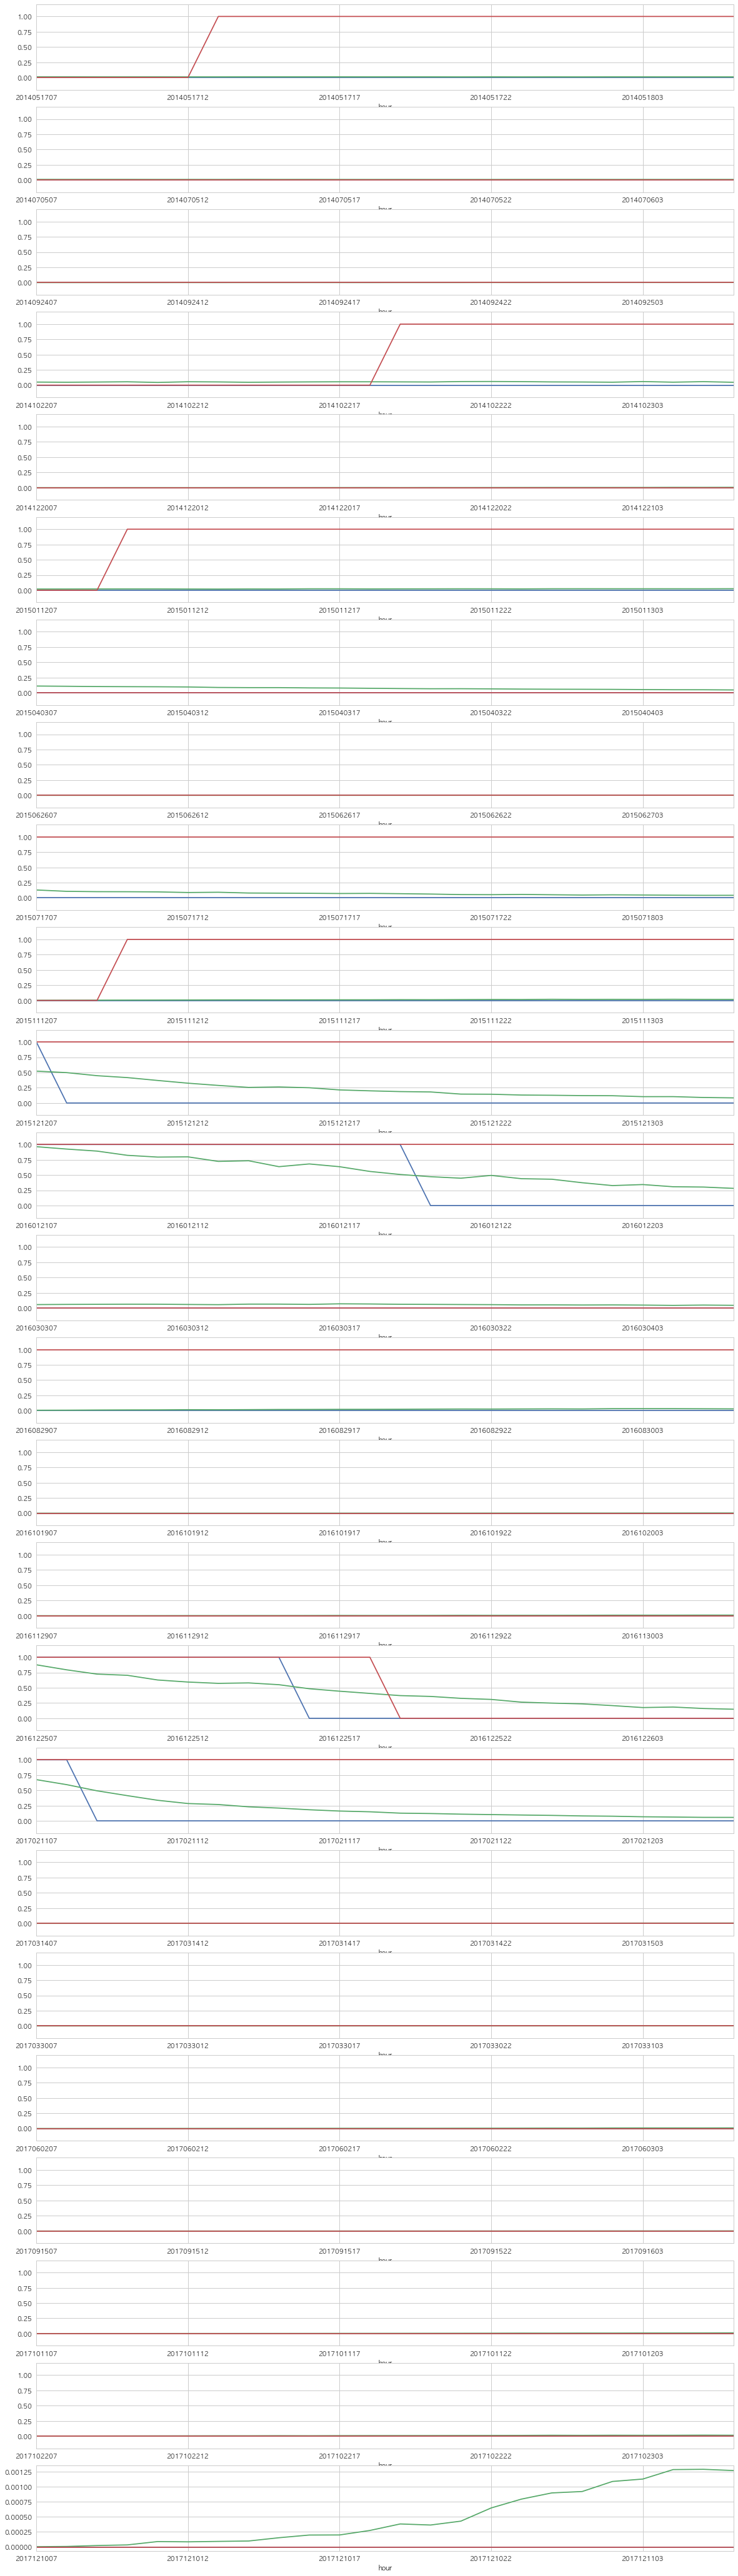

In [94]:
index = 0
for i in range(25):
    index = i*24
    plt.ylim(ymax=1.2,ymin=-0.2)
    plt.subplot(25,1,i+1)
    test.iloc[index:index+24]['pred_swell'].plot()
    #test.iloc[index:index+24]['eval_swell'].plot()
    test.iloc[index:index+24]['pred'].plot()
    real.iloc[index:index+24].plot()#.apply(lambda x:output_change(x)).plot()

In [95]:
index=0
test.iloc[index:index+24].T

hour,2014051707,2014051708,2014051709,2014051710,2014051711,2014051712,2014051713,2014051714,2014051715,2014051716,...,2014051721,2014051722,2014051723,2014051800,2014051801,2014051802,2014051803,2014051804,2014051805,2014051806
swell,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
pred,0.010995,0.011071,0.010629,0.010637,0.010722,0.010309,0.010305,0.010767,0.010872,0.010857,...,0.009959,0.010706,0.009891,0.010439,0.009953,0.01065,0.010516,0.010305,0.010305,0.010107
pred_swell,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [96]:
#eval_metric = evaluation(df['swell(t+1)'].apply(output_change))
eval_metric = evaluation(df['swell'].fillna(method='ffill'))

In [97]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test['pred_swell'].iloc[st:st + 24]))
    #print(test['pred_swell'][st:st+24].value_counts())

print(scores)

0
-2    18
 1     6
dtype: int64
24
1    24
dtype: int64
48
1    24
dtype: int64
72
-2    12
 1    12
dtype: int64
96
1    24
dtype: int64
120
-2    21
 1     3
dtype: int64
144
1    24
dtype: int64
168
1    24
dtype: int64
192
-2    24
dtype: int64
216
-2    21
 1     3
dtype: int64
240
-2    21
 0     2
 2     1
dtype: int64
264
 2    13
-2     9
 0     2
dtype: int64
288
1    24
dtype: int64
312
-2    24
dtype: int64
336
1    24
dtype: int64
360
1    24
dtype: int64
384
 1    12
 2     9
 0     2
-2     1
dtype: int64
408
-2    20
 2     2
 0     2
dtype: int64
432
1    24
dtype: int64
456
1    24
dtype: int64
480
1    24
dtype: int64
504
1    24
dtype: int64
528
1    24
dtype: int64
552
1    24
dtype: int64
576
1    24
dtype: int64
[-30, 24, 24, -12, 24, -39, 24, 24, -48, -39, -40, 8, 24, -48, 24, 24, 28, -36, 24, 24, 24, 24, 24, 24, 24]


In [98]:
np.sum(scores)

104

In [99]:
imp_features

[]

### parameter

| index | n_estimators | fl_score | acc |class2_f1_score| class2_acc | eval_score | detail|
| --- | --- | --- |--- |--- |--- |
|1 | 10 | 89 | 89|93|82|706| [21, 24, 24, 33, 24, 40, 24, 24, 38, 34, 39, 40, 24, 44, 24, 20, 31, 32, 22, 24, 24, 24, 24, 24, 24]|
|2|30|92|92|95.7|89|745|[30, 24, 24, 32, 24, 40, 24, 24, 44, 38, 42, 46, 24, 46, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]|
|3|30|92|92|95.3|88.4|738|[32, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 44, 24, 44, 24, 20, 34, 36, 22, 24, 24, 24, 24, 24, 24]
|4|30|93|93|95.2|88.4|737|[30, 24, 24, 32, 24, 42, 24, 24, 42, 36, 41, 46, 24, 44, 24, 20, 34, 38, 20, 24, 24, 24, 24, 24, 24]
|5|50|92|92|95.0|86.9|730|[23, 24, 24, 29, 24, 40, 24, 24, 42, 36, 43, 46, 24, 44, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]
|6|50|91.8|91.8|95.3|88.4|735|[27, 24, 24, 31, 24, 40, 24, 24, 42, 40, 41, 44, 24, 44, 24, 20, 32, 38, 24, 24, 24, 24, 24, 24, 24]
|7|50|93|93|96|90|744|[33, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 46, 24, 44, 24, 22, 33, 38, 22, 24, 24, 24, 24, 24, 24]
|8|100|93|93|95.7|89.3|744|[26, 24, 24, 33, 24, 40, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 38, 24, 24, 24, 24, 24, 24, 24]
|9|100|93|93|96.8|91.7|750|[29, 24, 24, 33, 24, 42, 24, 24, 44, 36, 46, 46, 24, 44, 24, 22, 34, 38, 24, 24, 24, 24, 24, 24, 24]
|10|100|94|93.9|96.5|92.2|752|[35, 24, 24, 33, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 33, 38, 20, 24, 24, 24, 24, 24, 24]
|11|150|93|93|95.8|90.3|745|[32, 24, 24, 33, 24, 42, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 34, 22, 24, 24, 24, 24, 24, 24]
|12|150|93.6|93.6|96.7|91.3|753|[35, 24, 24, 31, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 34, 36, 24, 24, 24, 24, 24, 24, 24]|
|13|150|93.8|93.8|96.5|91.3|754|[36, 24, 24, 33, 24, 42, 24, 24, 42, 40, 41, 46, 24, 44, 24, 22, 34, 40, 22, 24, 24, 24, 24, 24, 24]
|14|200|92.6|92.6|95.5|88.8|736|[28, 24, 24, 33, 24, 40, 24, 24, 44, 36, 43, 46, 24, 44, 24, 20, 34, 34, 22, 24, 24, 24, 24, 24, 24]
|15|200|94|94|96.8|92.2|756|[35, 24, 24, 33, 24, 42, 24, 24, 44, 40, 45, 46, 24, 44, 24, 22, 33, 36, 24, 24, 24, 24, 24, 24, 24]
|16|200|92.8|92.8|95.7|89.3|741|[34, 24, 24, 33, 24, 40, 24, 24, 44, 40, 41, 46, 24, 44, 24, 22, 33, 30, 22, 24, 24, 24, 24, 24, 24]